# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [1]:
# Enter your information here
first_and_last_name = 'Farzan rahmani'
std_number = '403210725'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision

from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader

Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    # pass
    # Compute mean and variance for each feature
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    # Normalize the input data
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)

    # Scale and shift
    return gamma * x_normalized + beta


In [ ]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [5]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_subset = Subset(train_set, range(len(train_set) // 2))
train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
*answer*

In `transform_train`, we applied the following transformations to the training data:
1. `RandomResizedCrop(224, scale=(0.5, 1.0))`: Randomly crops the image to a size of 224x224 with a scale between 0.5 and 1.0.
2. `RandomHorizontalFlip()`: Randomly flips the image horizontally.
3. `ToTensor()`: Converts the image to a PyTorch tensor.
4. `Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])`: Normalizes the image channels separately with the specified mean and standard deviation.

In `transform_test`, we applied the following transformations to the test data:
1. `Resize((224,224))`: Resizes the image to 224x224.
2. `ToTensor()`: Converts the image to a PyTorch tensor.
3. `Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])`: Normalizes the image channels separately with the specified mean and standard deviation.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

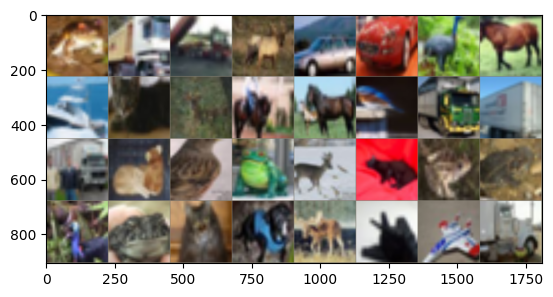

    6     9     9     4     1     1     2     7     8     3     4     7     7     2     9     9     9     3     2     6     4     3     6     6     2     6     3     5     4     0     0     9
 frog truck truck  deer automobile automobile  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer airplane airplane truck

labels are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])


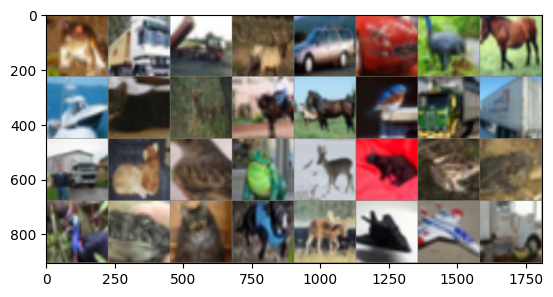

In [6]:
def imshow(img):
    # img = img / 2 + 0.5  # Unnormalize the image for display
    # np_img = img.numpy()
    # plt.imshow(np.transpose(np_img, (1, 2, 0)))
    # plt.show()

    # Inverse normalization
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]

    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)

    # Convert to numpy array and transpose dimensions
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show some training images with shuffle=False and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
print(' '.join('%5s' % int(labels[j]) for j in range(32)))
print(' '.join('%5s' % train_set.classes[labels[j]] for j in range(32)))
print("\nlabels are:", labels)

# show them again to check the augmentation
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

# create train loader with shuffle true
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [7]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    # pass
    epoch_losses = []
    correct = 0
    total = 0

    # Set model to train or eval mode
    model.train() if train_mode else model.eval()

    # for images, labels in data_loader:
    for images, labels in tqdm(data_loader, desc="Processing", leave=True):

        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        if train_mode:
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = np.mean(epoch_losses)
    accuracy = correct / total

    # Print loss and accuracy
    mode = "Training" if train_mode else "Validation"
    print(f'{mode}: Loss: {avg_loss:.4f}, {mode} Accuracy: {accuracy:.4f}')

    return epoch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    # pass
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"EPOCH # {epoch + 1} \ {epochs}")

        train_loss = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        train_losses.extend(train_loss)
        val_losses.extend(val_loss)

        # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    # pass
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        # for inputs, targets in val_loader:
        for inputs, targets in tqdm(val_loader, desc="Evaluating", leave=True):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return correct / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10,
    t_loader: DataLoader = train_loader,
    val_loader: DataLoader = val_loader
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    # # pass
    # plt.figure(figsize=(10, 5))
    # plt.plot(np.convolve(train_losses, np.ones(c_window)/c_window, mode='valid'), label='Train Loss')
    # plt.plot(np.convolve(val_losses, np.ones(c_window)/c_window, mode='valid'), label='Val Loss')
    # plt.plot(val_losses, label='Val Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(np.convolve(train_losses, np.ones(c_window)/c_window, mode='valid'), label='Train Loss')
    mean_val_losses_index = []
    mean_val_losses_in_epoch = []
    j = 1
    for i in range(len(val_loader), len(val_losses) + 1, len(val_loader)):
        # last_val_losses_in_epoch.append(val_losses[i - 1])
        mean_val_losses_in_epoch.append(np.mean(val_losses[i-len(val_loader):i]))
        mean_val_losses_index.append(len(t_loader) * j)
        j += 1
    plt.plot(mean_val_losses_index, mean_val_losses_in_epoch, label='Val Loss')

    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [8]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution

    # pass
    return nn.Sequential(
        # nn.Conv2d(inp, oup, 3, stride, 1, bias=True),
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution

    # pass
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**

Depthwise Separable Convolutions help in reducing the number of parameters and making the model faster by splitting the convolution operation into two parts: depthwise convolution and pointwise convolution.

1. **Depthwise Convolution**: Applies a single filter to each input channel independently. This significantly reduces the number of parameters and computations.
2. **Pointwise Convolution**: Combines the channels outputted by the depthwise convolution by applying a 1x1 filter. This allows the model to learn interactions between different channels.

**Parameter Calculation**:
- **Normal Convolution**: For an input of size \( H * W * C \) and a filter of size \( K * K * C * M \), the number of parameters is \( K * K * C * M \).
- **Depthwise Separable Convolution**: For the same input and filter sizes, the number of parameters is \( K * K * C + C * M \).

**Computation Comparison**:
- **Normal Convolution**: \( H * W * K * K * C * M \)
- **Depthwise Separable Convolution**: \( H * W * K * K * C + H * W * C * M \)

The reduction in parameters and computations makes the model faster and more efficient, especially for mobile and embedded applications.


Now please create your model.

In [9]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        # pass
        self.features = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),

            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),

            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1)
        )

        self.classifier = nn.Sequential(
            # nn.Dropout(0.5),
            nn.Linear(1024, n_class),
        )


    def forward(self, x):
        # pass
        x = self.features(x)
        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 10
lr = 1e-3
# TODO:
model = MobileNet(n_class=10).to(device)
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

start = time.time()
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)
end = time.time()
print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print("Training time: {:0.4f} s".format(end - start))

EPOCH # 1 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 1.6529, Training Accuracy: 0.3925


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 1.4642, Validation Accuracy: 0.4782
EPOCH # 2 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 1.3420, Training Accuracy: 0.5200


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 1.2594, Validation Accuracy: 0.5388
EPOCH # 3 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 1.1419, Training Accuracy: 0.5928


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 1.0547, Validation Accuracy: 0.6325
EPOCH # 4 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 1.0048, Training Accuracy: 0.6432


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.9554, Validation Accuracy: 0.6641
EPOCH # 5 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 0.8962, Training Accuracy: 0.6840


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.9045, Validation Accuracy: 0.6824
EPOCH # 6 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 0.8041, Training Accuracy: 0.7192


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.8275, Validation Accuracy: 0.7118
EPOCH # 7 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 0.7253, Training Accuracy: 0.7477


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.8746, Validation Accuracy: 0.7118
EPOCH # 8 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 0.6735, Training Accuracy: 0.7644


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.6911, Validation Accuracy: 0.7642
EPOCH # 9 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 0.6263, Training Accuracy: 0.7788


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.6861, Validation Accuracy: 0.7594
EPOCH # 10 \ 10


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 0.5842, Training Accuracy: 0.7972


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 0.6456, Validation Accuracy: 0.7725
Batch_size=128, epochs=10, lr=0.001
Training time: 1600.6937 s


Get some metrics and plot your losses.

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7725
Process validation time: 30.5353 s


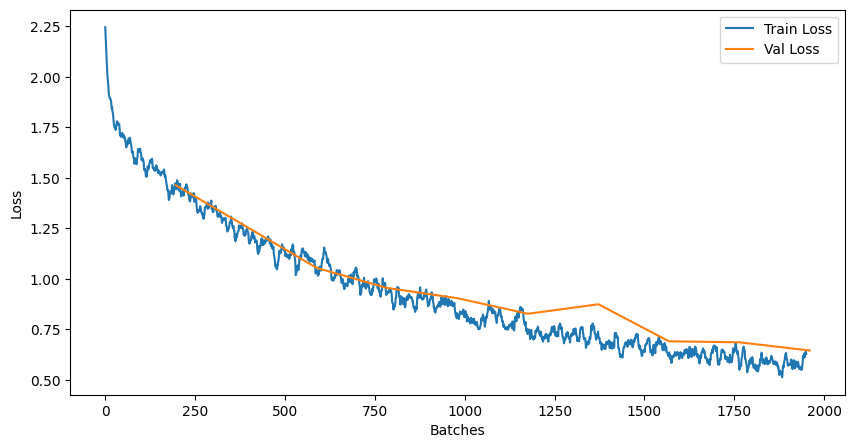

In [ ]:
plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**


The MobileNet paper claims that depthwise separable convolutions are 8 to 9 times faster than standard convolutions. This claim is based on the theoretical computation of FLOPs (Floating Point Operations Per Second).

**FLOPs Calculation**:
- **Standard Convolution**: For an input of size \( $ H \times W \times C $ \) and a filter of size \( $ K \times K \times C \times M $ \), the number of FLOPs is \( $ H \times W \times K \times K \times C \times M $ \).
- **Depthwise Separable Convolution**: For the same input and filter sizes, the number of FLOPs is \( $ H \times W \times K \times K \times C + H \times W \times C \times M = H \times W \times C \times (K \times K + M) $ \).

**Comparison**:
- For a typical layer, the reduction in FLOPs is approximately \( $ \frac{K \times K \times C \times M}{K \times K \times C + C \times M} $ \).
- This ratio simplifies to \( $ \frac{K^2 \times M}{K^2 + M} $ \).

For common values of \( $ K $ \) (e.g., 3) and \( $ M $ \) (e.g., 128), this ratio is approximately 8 to 9 (8.409), indicating that depthwise separable convolutions are significantly more efficient than standard convolutions.


## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
# TODO: train model

MODEL_SAVE_PATH = './normal_cnn_model.pt'
normal_cnn_model = NormalCNN(n_class=10).to(device)

# Train the model for 2 epochs
epochs = 2
lr = 1e-3

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

start = time.time()
train_losses, val_losses = train(train_loader, val_loader, normal_cnn_model, epochs, lr)
end = time.time()
print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print("Training time: {:0.4f} s".format(end - start))

EPOCH # 1 \ 2


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 1.9410, Training Accuracy: 0.2645


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 1.8523, Validation Accuracy: 0.2952
EPOCH # 2 \ 2


Processing:   0%|          | 0/196 [00:00<?, ?it/s]

Training: Loss: 1.7367, Training Accuracy: 0.3446


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 1.8453, Validation Accuracy: 0.3350
Batch_size=128, epochs=2, lr=0.001
Training time: 464.9217 s


In [ ]:
start = time.time()
val_acc = get_acc(normal_cnn_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.335
Process validation time: 38.5879 s


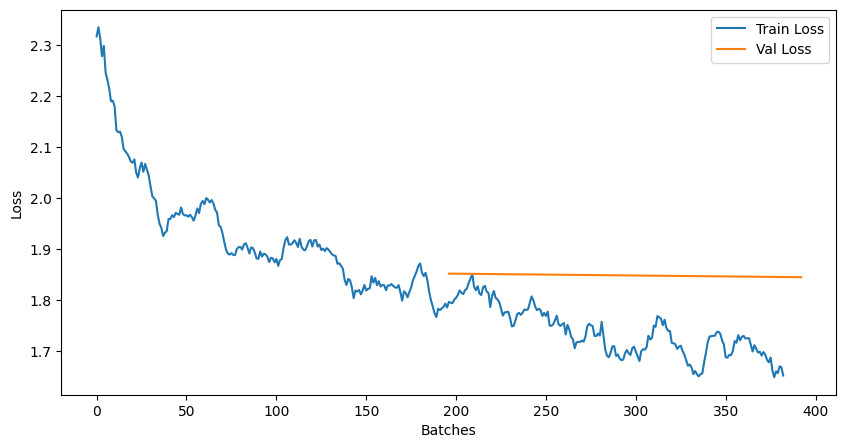

In [ ]:
plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**


The speed of learning and validating in Normal CNN vs MobileNet can be compared based on the training and validation times. From the previous training and validation steps, we can observe the time taken for each model.

For MobileNet:
- Training time for 10 epochs: [1600.6937 s]
- Training time for 1 epochs: [160.06937 s]
- Validation time: [30.5353 s]

For Normal CNN:
- Training time for 2 epochs: [464.9217 s]
- Training time for 1 epochs: [232.46085]
- Validation time: [38.5879 s]

By comparing these times, we can see that MobileNet is significantly faster in both training and validation due to its use of depthwise separable convolutions, which reduce the number of parameters and computations.

In other words:
1. NormalCNN has significantly more parameters compared to MobileNet, resulting in slower training and validation times.
2. MobileNet uses depthwise separable convolutions, which reduce the computational cost and make it faster for both training and inference.
3. For NormalCNN, training and validation take longer due to its larger parameter count and the use of standard convolutional layers.
4. Despite its slower speed, NormalCNN might achieve similar or slightly better accuracy depending on the task, but its efficiency is much lower.


In [ ]:
# TODO: compare number of parameters in these two models

# model = MobileNetV2(n_class=1000)
normalcnn_params = sum(p.numel() for p in normal_cnn_model.parameters() if p.requires_grad)
mobilenet_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters in NormalCNN:", normalcnn_params)
print("Number of parameters in MobileNet:", mobilenet_params)

Number of parameters in NormalCNN: 28279338
Number of parameters in MobileNet: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [16]:
model = MobileNet(n_class=100).to(device)

# Todo:

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
MODEL_SAVE_PATH = './model.pt'
pretrained_dict = torch.load(MODEL_SAVE_PATH)

# Filter out unnecessary keys from the pretrained dict
model_dict = model.state_dict()
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k != 'classifier.0.weight' and k != 'classifier.0.bias'}
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'classifier' not in k}


# Load the updated state dict into the model
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)


<ipython-input-16-2f430590f71c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(MODEL_SAVE_PATH)


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [17]:
# Freeze up to the desired layer (e.g., the first 7 layers)
for param in model.features[:7].parameters():
    param.requires_grad = False

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [18]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=False, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

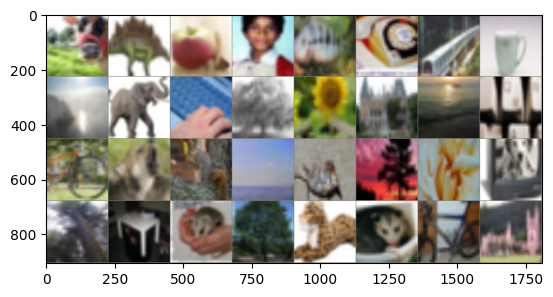


labels are: tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17, 47, 65, 21, 22,
        81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87,  9,
        71,  6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50,
        15, 89, 36, 18, 89, 46, 33, 42, 39, 64, 75, 38, 23, 42, 66, 77, 49, 18,
        46, 15, 35, 69, 95, 83, 75, 99, 73, 93, 55, 39,  4, 97, 61, 93, 51, 69,
        56, 84, 59, 64, 94,  4, 11, 33, 68, 38, 20, 33, 34, 32, 46, 53, 88, 67,
        70, 64])


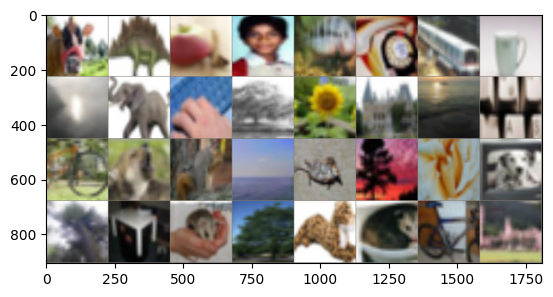

In [19]:
# show some training images with shuffle=False and labels
dataiter = iter(train_loader100)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))
# print(' '.join('%5s' % int(labels[j]) for j in range(32)))
print("\nlabels are:", labels)

# show them again to check the augmentation
dataiter = iter(train_loader100)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

# # create train loader with shuffle true
train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

Do CIFAR10 and CIFAR100 use the same images but with diffrent labels?(maybe you should search)

**answer**

No, CIFAR-10 and CIFAR-100 do not use the same images. Both datasets contain different images, although they are both subsets of the 80 million tiny images dataset. CIFAR-10 has 10 classes, while CIFAR-100 has 100 classes. The images in CIFAR-100 are more fine-grained and diverse compared to CIFAR-10.
In other words, CIFAR10 and CIFAR100 share the same 32x32 image format, but the classes are different. CIFAR10 has 10 classes, whereas CIFAR100 has 100 classes.  They don't share the exact same images but belong to the same dataset family.

***The CIFAR-10 dataset:***
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

***The CIFAR-100 dataset:***
This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).


more detail here:
https://www.cs.toronto.edu/~kriz/cifar.html


Now train your model using your functions.

In [20]:
epochs = 7
lr = 2e-4
MODEL_SAVE_PATH = './transfer_learning_model_cifar100.pt'
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

EPOCH # 1 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 3.9224, Training Accuracy: 0.1226


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 3.3154, Validation Accuracy: 0.2022
EPOCH # 2 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 3.0986, Training Accuracy: 0.2436


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 2.8152, Validation Accuracy: 0.2912
EPOCH # 3 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 2.7266, Training Accuracy: 0.3115


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 2.5472, Validation Accuracy: 0.3304
EPOCH # 4 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 2.4967, Training Accuracy: 0.3542


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 2.4148, Validation Accuracy: 0.3635
EPOCH # 5 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 2.3384, Training Accuracy: 0.3795


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 2.2663, Validation Accuracy: 0.3936
EPOCH # 6 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 2.2003, Training Accuracy: 0.4117


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 2.1924, Validation Accuracy: 0.4133
EPOCH # 7 \ 7


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Training: Loss: 2.1037, Training Accuracy: 0.4325


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

Validation: Loss: 2.1174, Validation Accuracy: 0.4225


Get some metrics and plot your losses.

In [21]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.4225
Process validation time: 20.0306 s


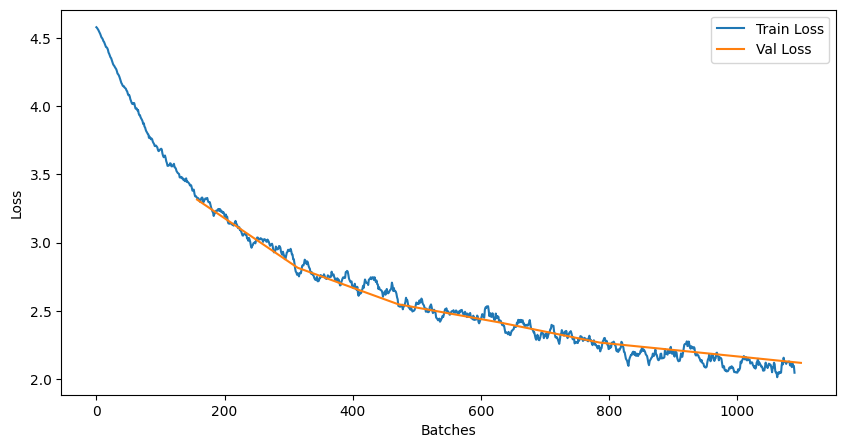

In [22]:
plot_losses(train_losses, val_losses, 10, train_loader100, val_loader100)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now whe are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer**

The ReLU6 activation function is a variant of the ReLU (Rectified Linear Unit) activation function that clips the output at 6. Mathematically, it is defined as:

ReLU6(x) = min(max(0, x), 6)

ReLU6 is used because it helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices. By limiting the output to a maximum value of 6, it ensures that the activations remain within a manageable range, which is beneficial for hardware accelerators and low-precision arithmetic. In other words, This helps prevent numerical instability, especially in low-precision computations, which is crucial for mobile applications.


In [25]:
def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    # pass
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # pass
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size

        # pass
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        # Determine if a skip connection should be used
        # (only used when stride is 1 and input channels == output channels)
        self.use_res_connect = self.stride == 1 and inp == oup

        # Calculate the number of hidden channels after expansion
        hidden_dim = int(inp * expand_ratio)


        # If expand_ratio is 1, skip the initial pointwise convolution
        if expand_ratio == 1:
                # pass
                # Depthwise convolution

                # Pointwise-linear convolution
                self.conv = nn.Sequential(
                    # Depthwise convolution
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(inplace=True),

                    # Pointwise-linear convolution
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )


        else:
                pass
                # Pointwise convolution to increase channel depth

                # Depthwise convolution

                # Pointwise-linear convolution to reduce channel depth
                self.conv = nn.Sequential(
                    # Pointwise convolution to increase channel depth
                    # conv_1x1_bn(inp, hidden_dim),
                    nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(inplace=True),

                    # Depthwise convolution
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(inplace=True),

                    # Pointwise-linear convolution to reduce channel depth
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )


    def forward(self, x):
        # Forward pass with optional residual connection
        # pass
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [26]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):

        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]
        # pass
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        # building first layer
        input_channel = int(input_channel * width_multiplier)
        self.last_channel = int(last_channel * width_multiplier)
        self.features = [conv_bn(3, input_channel, 2)]

        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel

        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            # nn.Dropout(0.2), # to avoid overfitting
            nn.Linear(self.last_channel, n_class),
        )


    def forward(self, x):
        # pass
        x = self.features(x)
        x = x.mean(3).mean(2)  # Global Average Pooling
        # x = F.avg_pool2d(x, 7) # result is same as Global Average Pooling because the input size is 7*7
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


**answer**

Linear bottlenecks are created by using linear layers instead of non-linear layers like ReLU in the bottleneck stages. In MobileNetV2, this is achieved by using a pointwise-linear convolution (1x1 convolution) after the depthwise convolution. This helps preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model. In other words, Linear bottlenecks help preserve information during compression and expansion of channels. By avoiding ReLU in bottleneck layers, they prevent unnecessary loss of information.



Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [27]:
import gc
gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Fri Dec  6 11:14:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              30W /  70W |   1589MiB / 15360MiB |     45%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [29]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

EPOCH # 1 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 1.6625, Training Accuracy: 0.3870


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 1.5263, Validation Accuracy: 0.4372
EPOCH # 2 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 1.3184, Training Accuracy: 0.5236


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 1.5185, Validation Accuracy: 0.5000
EPOCH # 3 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 1.1395, Training Accuracy: 0.5923


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 1.2088, Validation Accuracy: 0.5852
EPOCH # 4 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 1.0074, Training Accuracy: 0.6416


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 0.9338, Validation Accuracy: 0.6695
EPOCH # 5 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 0.8961, Training Accuracy: 0.6845


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 1.1113, Validation Accuracy: 0.6326
EPOCH # 6 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 0.8130, Training Accuracy: 0.7108


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 0.7928, Validation Accuracy: 0.7288
EPOCH # 7 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 0.7563, Training Accuracy: 0.7355


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 0.7689, Validation Accuracy: 0.7387
EPOCH # 8 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 0.7054, Training Accuracy: 0.7527


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 0.7745, Validation Accuracy: 0.7376
EPOCH # 9 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 0.6715, Training Accuracy: 0.7652


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 0.6414, Validation Accuracy: 0.7802
EPOCH # 10 \ 10


Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Training: Loss: 0.6431, Training Accuracy: 0.7795


Processing:   0%|          | 0/157 [00:00<?, ?it/s]

Validation: Loss: 0.7050, Validation Accuracy: 0.7601


Get some metrics and plot your losses.

In [30]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(64, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=64, epochs=10, lr=0.001
Val accuracy = 0.7601
Process validation time: 27.7615 s


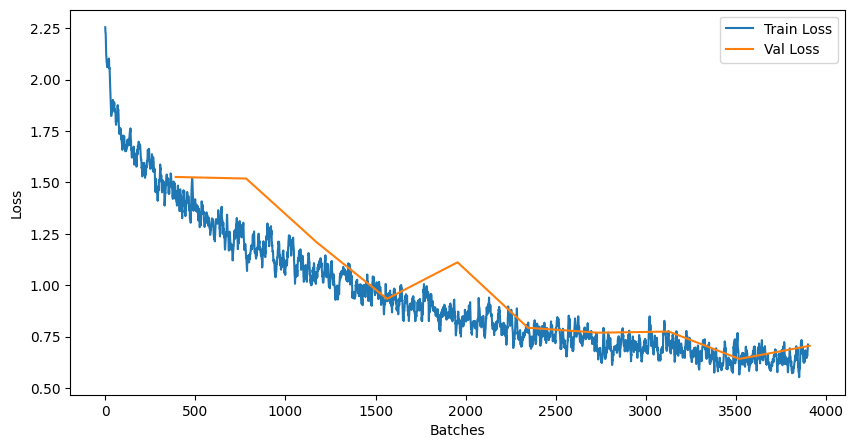

In [31]:
plot_losses(train_losses, val_losses, 10, train_loader, val_loader)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [ ]:
# TODO
for width_multiplier in np.arange(0.1, 1.1, 0.1):
    model = MobileNetV2(n_class=10, width_multiplier=width_multiplier).to(device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'with {width_multiplier:.1f} Width Multiplier we got {num_params} Number of Parameters')

with 0.1 Width Multiplier we got 31255 Number of Parameters
with 0.2 Width Multiplier we got 105224 Number of Parameters
with 0.3 Width Multiplier we got 221676 Number of Parameters
with 0.4 Width Multiplier we got 380438 Number of Parameters
with 0.5 Width Multiplier we got 587178 Number of Parameters
with 0.6 Width Multiplier we got 826943 Number of Parameters
with 0.7 Width Multiplier we got 1113168 Number of Parameters
with 0.8 Width Multiplier we got 1441788 Number of Parameters
with 0.9 Width Multiplier we got 1812806 Number of Parameters
with 1.0 Width Multiplier we got 2236682 Number of Parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [37]:
MNv2_path = './MNv2WMmodel.pt'

# TODO
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)

pretrained_dict = torch.load(MNv2_path)

model_dict = model.state_dict()
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k != 'classifier.0.weight' and k != 'classifier.0.bias'}
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'classifier' not in k}

model_dict.update(pretrained_dict)

model.load_state_dict(model_dict)

<ipython-input-37-141043da01d0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(MNv2_path)


<All keys matched successfully>

In [38]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.7928
Process validation time: 26.6963 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**

The width multiplier (α) scales the number of channels in each layer, allowing you to shrink the model's width (number of channels). The formula to predict the number of parameters is:

Number of Parameters = α^2 * (Original Number of Parameters)

No they don't match perfectly. This is because both the input and output channels are scaled by α. However, this formula is an approximation and may not match perfectly due to rounding and other implementation details.


Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**

The resolution multiplier (ρ) reduces the resolution of the input image, further decreasing computational cost. It can make the model faster by reducing the number of operations required for each layer. However, it does not decrease the number of parameters, as the number of parameters is determined by the architecture of the model, not the resolution of the input image.


Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**

The number of parameters is important for several reasons:

1. **Memory Efficiency**: Models with fewer parameters require less memory, which is crucial for mobile and embedded devices with limited resources.
2. **Computational Efficiency**: Fewer parameters mean fewer computations, leading to faster inference times, which is essential for real-time applications.
3. **Energy Efficiency**: Reducing the number of parameters and computations can significantly lower power consumption, which is important for battery-operated devices.
4. **Deployment**: Smaller models are easier to deploy on edge devices and can be more easily integrated with hardware accelerators like Edge TPUs.

Even with powerful GPUs, the number of parameters is still a big deal because it directly impacts the model's efficiency, scalability, and practicality in real-world applications.


## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for our task, but because of lack of resources we will just use it with terrible accuracy)

In [ ]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

In [ ]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.109
Process validation time: 27.9087 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [ ]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        # pass
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        # pass
        # Scale logits with temperature
        student_logits = student_logits / self.temperature
        teacher_logits = teacher_logits / self.temperature

        kl_div_loss = self.kl_div_loss(F.log_softmax(student_logits, dim=1), F.softmax(teacher_logits, dim=1))
        cross_entropy_loss = self.cross_entropy_loss(student_logits, labels)

        loss = (1 - self.alpha) * cross_entropy_loss + self.alpha * (self.temperature ** 2) * kl_div_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        # pass
        student.train()
        running_loss = 0.0

        # for inputs, labels in train_loader:
        for inputs, labels in tqdm(train_loader, desc="Processing", leave=True):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            student_logits = student(inputs)
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Compute loss
            loss = criterion(student_logits, teacher_logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

    # Evaluate the student model
    student.eval()
    val_acc = get_acc(student, test_loader)
    print('Val accuracy =', val_acc)


Train it for one epoch to just check if it works.

In [ ]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Processing:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/1, Loss: 1.1232423373805287


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.4753


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**

The potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss are:

- **High Alpha (e.g., 0.9)**: Emphasizes the distillation loss more than the classification loss. This means the student model will focus more on mimicking the teacher's behavior rather than directly learning from the ground truth labels. This can lead to better alignment with the teacher's knowledge but may result in poorer generalization to the target task if the teacher's knowledge is not perfectly accurate.
   - Pros:
     - Better alignment with the teacher model's knowledge.
     - May result in a more generalizable model if the teacher captures useful, high-level features.
   - Cons:
     - Risk of overfitting to the teacher's mistakes or biases.
     - Might underperform on the target task if the teacher's knowledge is not fully aligned with it.

- **Low Alpha (e.g., 0.1)**: Emphasizes the classification loss more than the distillation loss. This means the student model will focus more on learning from the ground truth labels rather than mimicking the teacher's behavior. This can lead to better generalization to the target task but may result in poorer alignment with the teacher's knowledge, especially if the teacher's knowledge is more accurate than the ground truth labels.
   - Pros:
     - Stronger focus on target task performance.
     - Less reliance on the teacher, which can be beneficial if the teacher has limitations.
   - Cons:
     - Reduced transfer of the teacher's high-level knowledge, potentially leading to lower generalization.


In summary, the choice of alpha affects the balance between learning from the teacher's knowledge and learning from the ground truth labels. A higher alpha prioritizes the teacher's knowledge, while a lower alpha prioritizes the ground truth labels. The optimal value of alpha depends on the specific task and the quality of the teacher's knowledge. A balance between alpha values (e.g., 0.5) often provides the best trade-off, leveraging the teacher's knowledge while ensuring strong task performance.


## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

MobileNetV3 introduced several innovations to improve both efficiency and accuracy:
- **NAS Optimization:** Automated Neural Architecture Search (NAS) was used to design the network.
- **SE Modules:** Squeeze-and-Excitation (SE) blocks were added for better channel-wise feature recalibration.
- **Hard-Swish Activation:** Improved efficiency compared to traditional ReLU6.
- **Efficient Head Design:** Reduced complexity in the final classification layers.
- **Mix of Depthwise and Standard Convolutions:** Balanced computational efficiency and performance.

These changes made MobileNetV3 highly suitable for real-time applications and mobile deployment.


## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018